### Improvements 
## IMP: Fitrar por la surface--remove events that move out of the surface on the first 3 secons
1) Remove blinks and interpolate values using cubic splines
3) Frequency analysis of the signal??
4) Remove trials with z scores over [2,-2]
7) Statistics of signal ¿How to compare surprise signals?
8) Amplitud, velocidad de cambio
9) Cut the whole signal of interest from the beggining
10) Fitrar por la surface




In [3]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import sys
sys.path.append('../')
import commons as cm
from data_curation import Normalization
# from pandasql import sqldf
import pupillometry_commons as cp
from itertools import compress
import json
import pupillometry2_0_commons as pc
import importlib
from pyplr.plr import PLR
from pyplr import graphing
from pyplr import preproc
from pyplr import utils

importlib.reload(pc)
# importlib.reload(pupillometry2_0_commons)
nm=Normalization()

session_location = Path(r"D:/sessions")
sessions=[]
df_list=[]
df_list_raw=[]
df_list_params_assets=[]
df_list_params_suprise=[]
confidence_thr=1 #pupil condifedence for data cleaning
windows_s=3      #Seconds od interest for the signal
seconds_norm=0.05 #Baseline period for normalization

# Columns to load for pupil data
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']


with open('session.txt','r') as f:
    for session in f:
            sessions.append(session.replace('\n',''))
f.close()

session_loc_list=[session_location.joinpath(session,'01 Processing_data','pupil_labs') for session in sessions ]
session_raw_list=[session_location.joinpath(session, '00 Raw_data','pupil_labs') for session in sessions ]

image_loc_list=[session_location.joinpath(session,'images_order') for session in sessions ]

for subject, recording_location in zip(sessions,session_loc_list):
    recording_folder=[record for record in os.listdir(recording_location)  if '00' in record]
    print(recording_folder)
    index_aux = list(map(lambda x: not('_' in x), recording_folder))
    recording_folder=list(compress(recording_folder,index_aux))
    #Load data in folders
    if len(recording_folder)>1:
        ValueError('Ambiguty in folder of experiment')
    recording_location=recording_location.joinpath(recording_folder[0],'exports')
    recording_location_raw=recording_location.joinpath(recording_folder[0],'exports')
    export_folder=[record for record in os.listdir(recording_location)  if '00' in record]
    if len(export_folder)>1:
        ValueError('Ambiguty in folder of exports')
    recording_location=recording_location.joinpath(export_folder[0])

    gaze_surf_csv=[record for record in os.listdir(recording_location.joinpath('surfaces'))  if 'gaze_positions' in record][0]

    print(f'Analixing session: {subject}')

    exported_pupil_csv = recording_location.joinpath('pupil_positions.csv')
    pupil_pd_frame = pd.read_csv(exported_pupil_csv,usecols=use_cols)
    exported_gaze_csv = os.path.join(recording_location,'gaze_positions.csv')
    gaze_pd_frame = pd.read_csv(exported_gaze_csv)
    annotations_csv = os.path.join(recording_location,'annotations.csv')
    annotations_pd = pd.read_csv(annotations_csv)
    surface_gaze_csv = os.path.join(recording_location, 'surfaces',gaze_surf_csv)
    surfaces_pd_frame = pd.read_csv(surface_gaze_csv)

    df=pc.calculate_pupillometry(pupil_pd_frame,annotations_pd,recording_location,
                                 window_s=windows_s,
                                 seconds_norm=seconds_norm,
                                 signal_str='diameter_3d_cubic_z_score')


['ES001_S030_Script.txt', '005']
Analixing session: ES0001_S030_PC_EM


AttributeError: module 'pupillometry2_0_commons' has no attribute 'calculate_pupillometry'

### Filter data that is inside the surface
#### Due to the fact that te gaze timesatmp of the surface is obtained by combining data from both pupils we cant just merge by the timestamp. We have to read and duplicate values



### Cut all data by annotations of interest

In [15]:
# pupil_pd_frame=final_df

from IPython.display import display

event_initial=annotations_pd['label'].values[0]
event_final=annotations_pd['label'].values[-1]

initial_anotation,_,_=cm.extract_annotations_timestamps(event_initial,'label',annotations_pd)
end_anotation=annotations_pd.iloc[-1]
display(initial_anotation)
display(end_anotation)

pupil_pd_frame=cm.filter_rows_by_temporal_values(
         dataframe=pupil_pd_frame,
         time_column='pupil_timestamp',
         ini_value=initial_anotation['timestamp'].values[0],
         end_value=end_anotation['timestamp']
         )

,index,timestamp,label,duration
0,4834,13698.920251,blank_0,NaN


index                  37127
timestamp       14240.031138
label        EndOfExperiment
duration                 NaN
Name: 162, dtype: object

## Data cleaning
Extracting pupil 3d data for analysis:
1) Select eye that has a better signal
2) Clean blinks from data
3) Asses that quality

Now select eye with better data quality 

In [16]:
def extract_eye_data(pupil_df:pd.DataFrame,eye_id: str = 'best',
               method: str = 'pye3d 0.3.0 real-time',confidence_thr: float=0.95)-> pd.DataFrame:
    # TODO: Refactor function in smaller chunks-- clean code
    """Function to extract pupil data for eye of interest. 
    Left eye, right eye or best eye can be extracted for further analysis

    Args:
        pupil_df (pd.DataFrame): pupil pandas dataframe
        eye_id (str, optional): _description_. Defaults to 'best'.
        method (str, optional): _description_. Defaults to 'pye3d 0.3.0 real-time'.
        confidence_thr: Confidence thershold for data qualiltu filtering. Deafults to 0.95

    Raises:
        ValueError: a string must be put to indicate if we are using left, right eye or best

    Returns:
        pd.DataFrame: pandas dataframe with pupil data of interest
    """
    global SAMPLE_RATE
    pupil_df = pupil_df.loc[pupil_df.method.str.contains(method)]

    pupil_left_eye=pupil_df.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)]
    pupil_right_eye=pupil_df.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)]

    blinks_left_eye=pupil_df.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']< confidence_thr)]
    blinks_right_eye=pupil_df.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']< confidence_thr)]


    ##  Explore blinks and Asses data quality, are there many regions with data gaps? 
    parts = list(recording_location.parts)
    parts=parts[0:-2]
    parts=Path(*parts)
    f = open(parts.joinpath('info.player.json'))
    data = json.load(f)
    time_whole_recording=data['duration_s']
    time_roi_left=abs(pupil_left_eye['pupil_timestamp'].values[-1]-pupil_left_eye['pupil_timestamp'].values[0])
    time_roi_right=abs(pupil_right_eye['pupil_timestamp'].values[-1]-pupil_right_eye['pupil_timestamp'].values[0])

    pupil_sampling_freq_left=(pupil_left_eye.shape[0]+blinks_left_eye.shape[0])/time_roi_left
    pupil_sampling_freq_right=(pupil_right_eye.shape[0]+blinks_right_eye.shape[0])/time_roi_right 
    print(f'time of the whole recording is {time_whole_recording}')
    print(f'time after anottaion cutting {time_roi_left:.2f}s for left eye and {time_roi_right:.2f}s for right eye')
    print('sampling frequency for right eye is {}'.format(pupil_sampling_freq_right)) 
    print('sampling frequency for left eye is {}'.format(pupil_sampling_freq_left)) 
    # Closing file
    f.close()

    ### Asses data quality
    total_blinks_left=blinks_left_eye.shape[0]/pupil_sampling_freq_left
    total_blinks_right=blinks_right_eye.shape[0]/pupil_sampling_freq_right
    print(f'Total blinks time left {total_blinks_left:.2f}s and right {total_blinks_right:.2f}s of a total of {time_roi_left:.2f}s left and {time_roi_right:.2f}s right')
    print(f'Total blinks time left {total_blinks_left/time_roi_left:.2%} ')
    print(f'Total blinks time right {total_blinks_right/time_roi_right:.2%} ')

    if eye_id == 'left':
        pupil_df = pupil_df[pupil_df.eye_id == 1]
        SAMPLE_RATE=pupil_sampling_freq_left
    elif eye_id == 'right':
        pupil_df = pupil_df[pupil_df.eye_id == 0]
        SAMPLE_RATE=pupil_sampling_freq_right
    elif eye_id == 'best':
        best = pupil_df.groupby(['eye_id'])['confidence'].mean()
        display(best)
        best=best.idxmax()
        pupil_df = pupil_df[pupil_df.eye_id == best]
        eye='left'if best==1 else 'right'
        print(f'data from {eye} eye was selected')
        SAMPLE_RATE=pupil_sampling_freq_left if best==1 else pupil_sampling_freq_right
    else:
        raise ValueError('Eye must be "left", "right" or "best".')
    print('Loaded {} samples'.format(len(pupil_df)))
    return pupil_df


In [17]:
pupil_df_raw=extract_eye_data(pupil_df=pupil_pd_frame,
                          eye_id='best',
                          method='pye3d 0.3.0 real-time')



time of the whole recording is 649.0306049999999
time after anottaion cutting 540.86s for left eye and 541.06s for right eye
sampling frequency for right eye is 123.9418849697693
sampling frequency for left eye is 123.98769070322815
Total blinks time left 87.56s and right 118.72s of a total of 540.86s left and 541.06s right
Total blinks time left 16.19% 
Total blinks time right 21.94% 


eye_id
0    0.917017
1    0.924317
Name: confidence, dtype: float64

data from left eye was selected
Loaded 67060 samples


## Put timestamp data in seconds


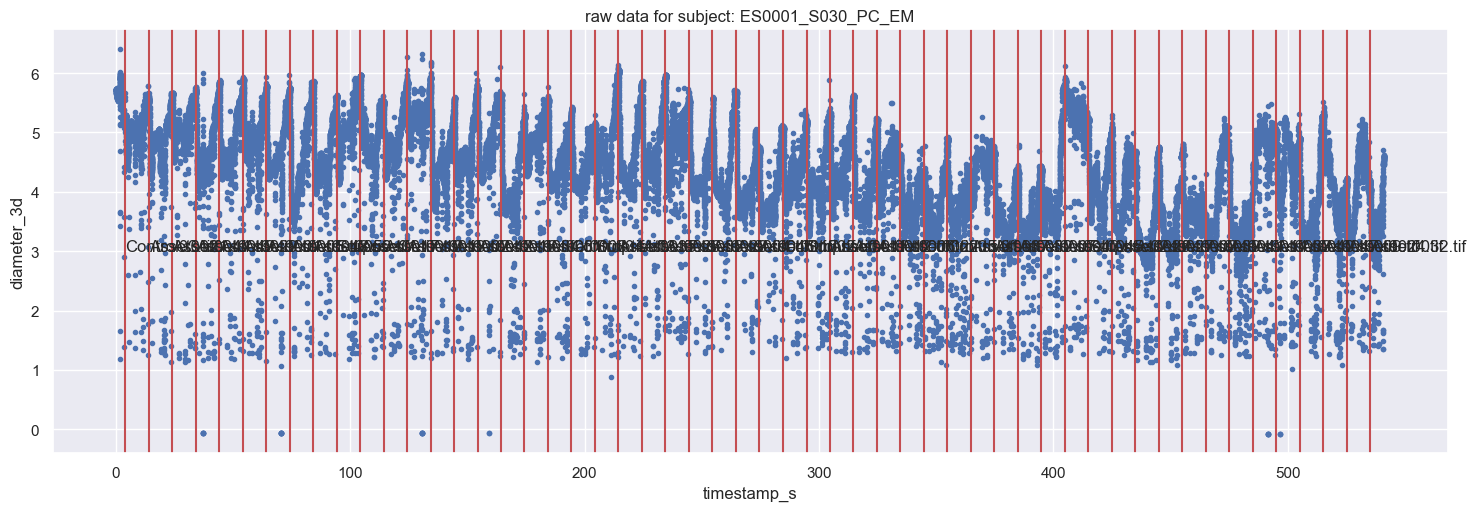

In [18]:
pupil_df_raw['timestamp_s']=pupil_df_raw['pupil_timestamp']-pupil_df_raw['pupil_timestamp'].values[0]
annotations_pd['timestamp_s']=annotations_pd['timestamp']-annotations_pd['timestamp'].values[0]

filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')

fig,ax=pc.plot_signal_with_events(signal_df=pupil_df_raw,
                           annotattion_df=annotations_pd[filter_events],
                           time_col='timestamp_s',
                           signal_col='diameter_3d')
ax.set_title(f'raw data for subject: {subject}')

fig.savefig(f'figures/{subject}_Raw.png', dpi=300)

## Blink cleaning data using pyplr

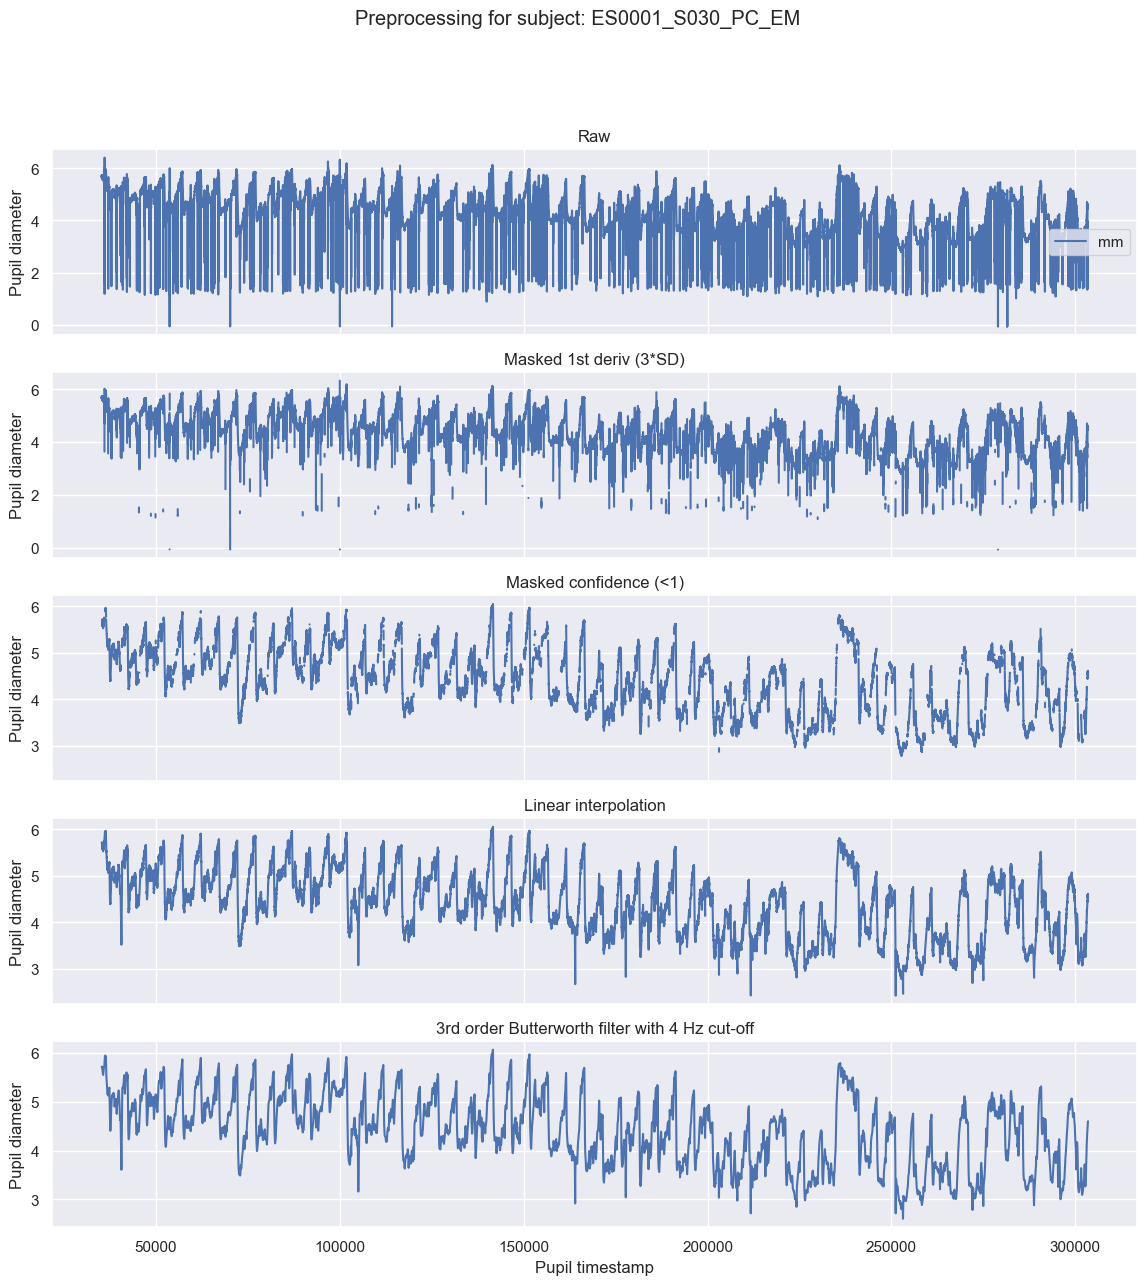

In [19]:

%matplotlib inline
# Sampling frequency
pupil_df=pupil_df_raw

# Pupil columns to analyse
pupil_cols = ['diameter_3d']

# Make figure for processing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=subject)

# Plot the raw data
pupil_df[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
pupil_df = preproc.mask_pupil_first_derivative(
    pupil_df, threshold=3.0, mask_cols=pupil_cols)
pupil_df[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
pupil_df = preproc.mask_pupil_confidence(
    pupil_df, threshold=confidence_thr, mask_cols=pupil_cols)
pupil_df[pupil_cols].plot(
    title=f'Masked confidence (<{confidence_thr})', ax=axs[2], legend=False)

# Interpolate
pupil_df = preproc.interpolate_pupil(
    pupil_df, interp_cols=pupil_cols)
pupil_df[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
pupil_df = preproc.butterworth_series(
    pupil_df, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
pupil_df[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);


f.savefig(f'figures/{subject}_Blinks.png', dpi=300)

In [20]:
pupil_df['diameter_3d_z_score']=nm.normalize(values=pupil_df['diameter_3d'],
                                                type='z_score')

Initial frames used for normalization = 6 correspond to 0.05s
Windows frames of interest   = 372 correspond to 3s


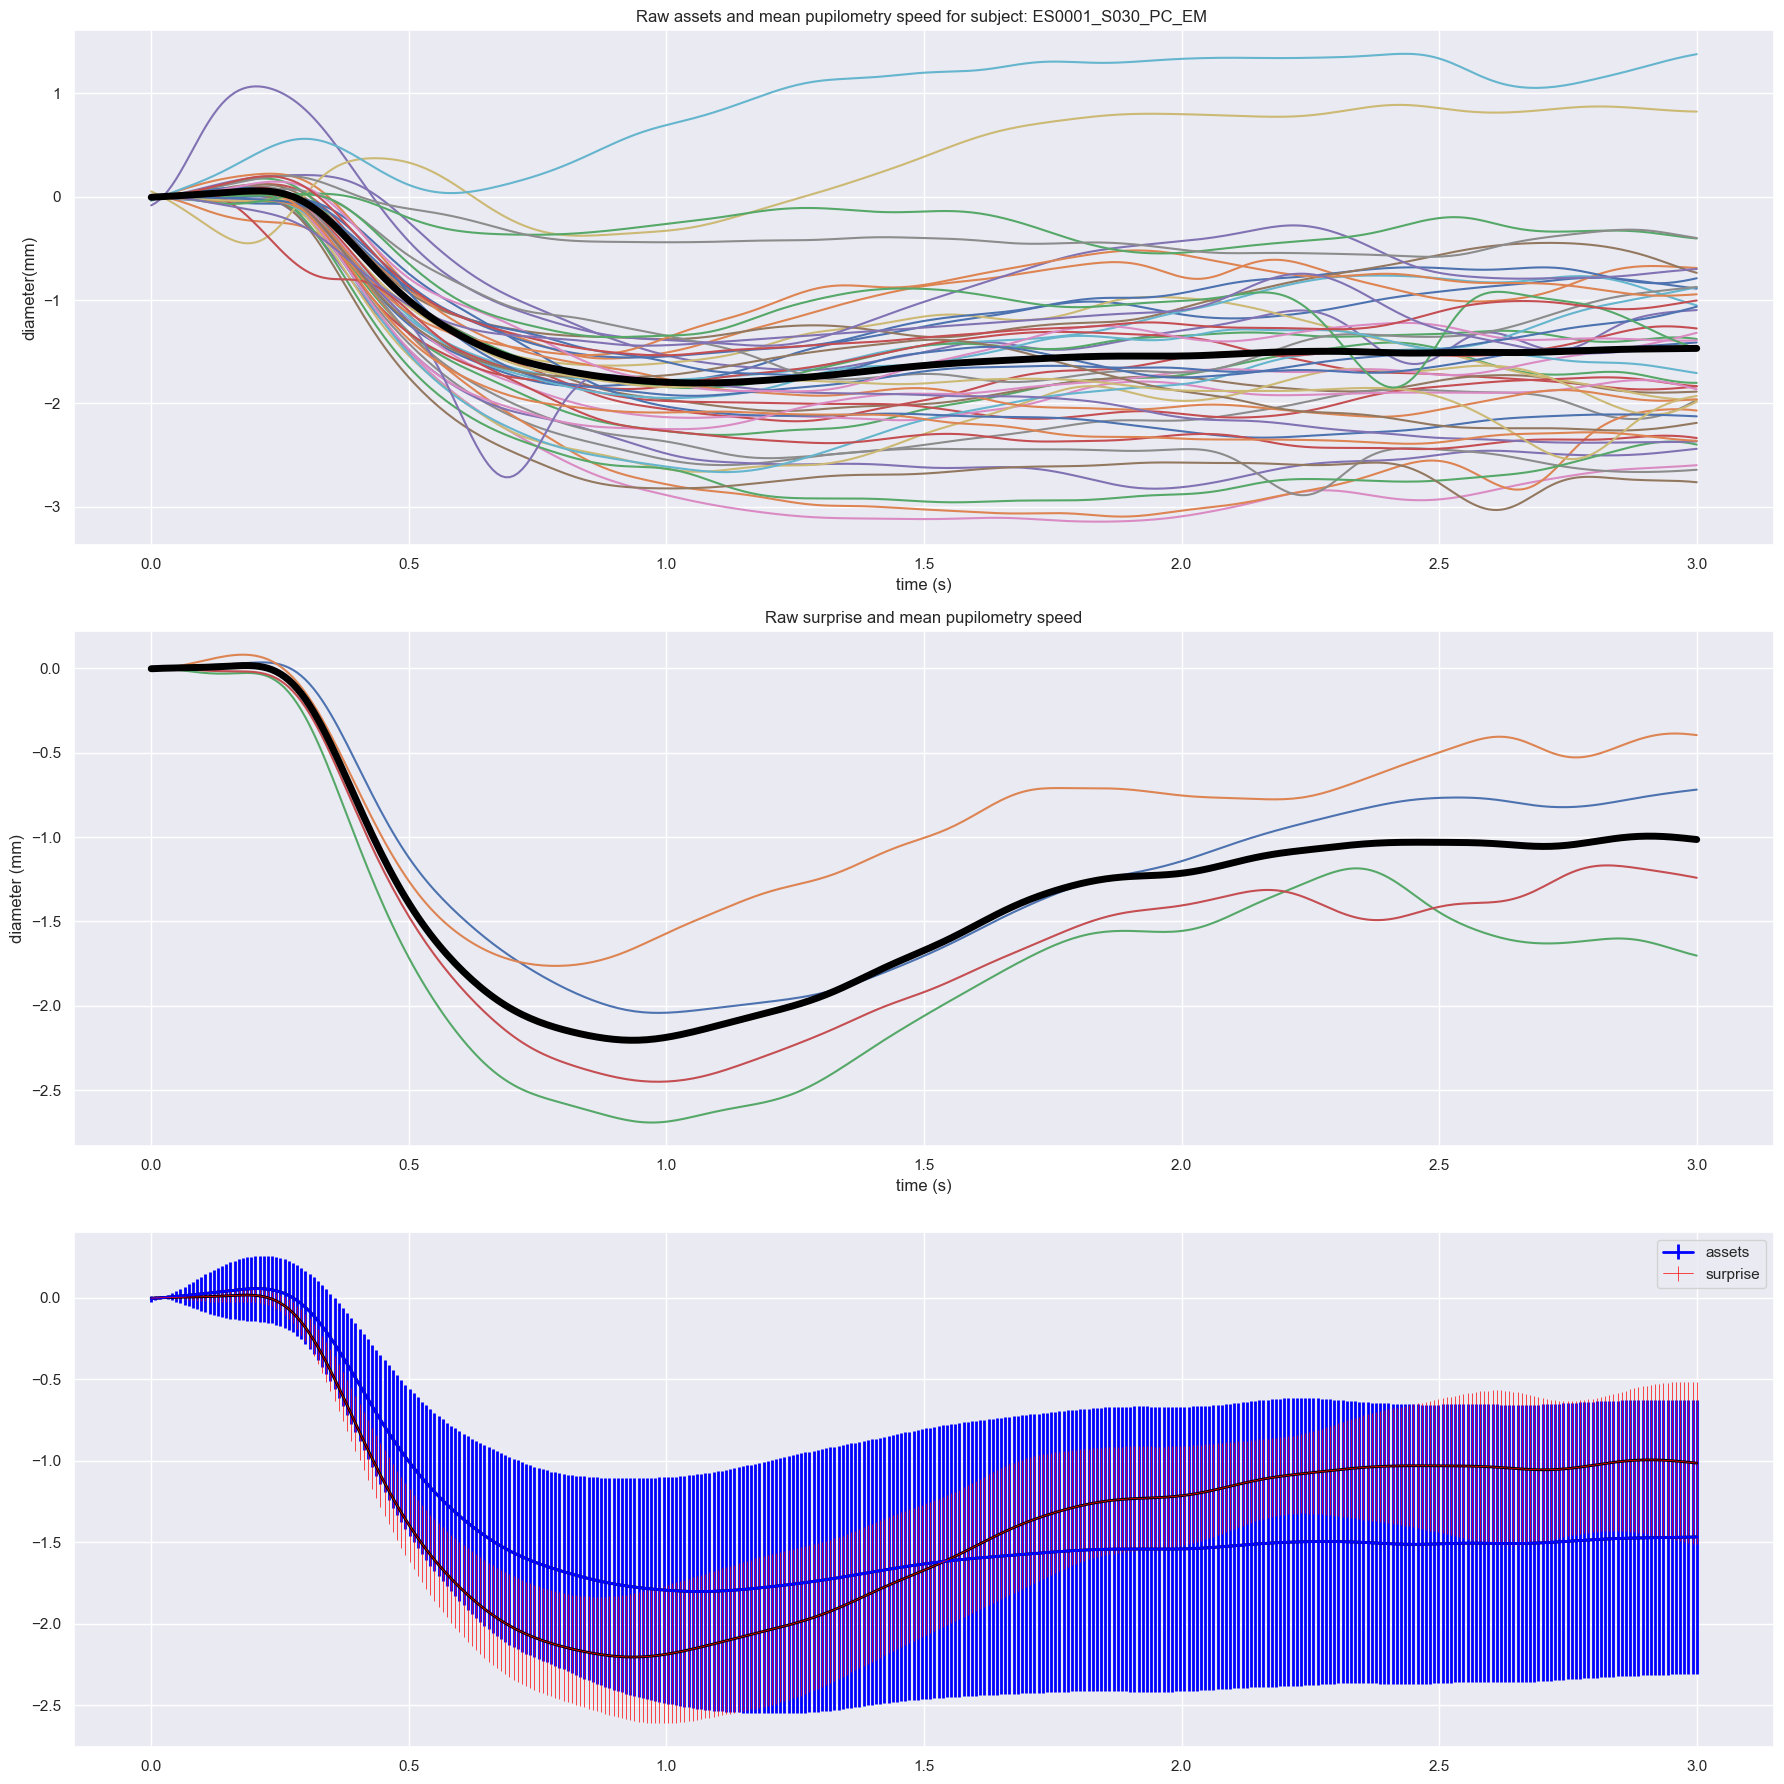

In [38]:
window_s=3
seconds_norm=0.05
signal_str='diameter_3d_z_score'

filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')

frames_norm=np.round(seconds_norm*SAMPLE_RATE).astype(int)
win_norm=range(frames_norm)
print('Initial frames used for normalization = {} correspond to {}s'.format(frames_norm,seconds_norm))

window_frames=np.round(window_s*SAMPLE_RATE).astype(int)
print('Windows frames of interest   = {} correspond to {}s'.format(window_frames,window_s))
window=range(0,window_frames)
time_x=np.linspace(0,window_s,window_frames)

# For Assets only window size data
event=annotations_pd.loc[filter_events,['label']].values.flatten()
event_strip=[image.split('.')[0] for image in event] #remove .tiiff

# event=annotations_pd['label'].values.flatten()
data_dict=dict([(key,[None]) for key in event_strip])# dict with empty keys 
data_dict_raw=dict([(key,[None]) for key in event_strip])# dict with empty keys 
data_dict_params=dict([(key,[None]) for key in event_strip])# dict with empty keys 

pupil_diameter_df=pd.DataFrame()#pd.DataFrame(data_dict,index=np.arange(0,800))
for im,im_strip in zip(event,event_strip):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )
    
    segmented_df=segmented_df.iloc[window]
    win_blank=segmented_df.iloc[win_norm]
    asset_norm=segmented_df[signal_str]-win_blank[signal_str].mean()
    asset_raw=segmented_df[signal_str]

    data_dict[im_strip]=asset_norm.values
    data_dict_raw[im_strip]=asset_raw.values

    #Here we should add the dataframe for the extracted params
    #Tomorrow understand calculations of these params and do the statistics

#Create dataframes of interest
pupil_diameter_df=pd.DataFrame(data_dict)
pupil_diameter_df_raw=pd.DataFrame(data_dict_raw)

#To filter assets
filter_assets=list(pupil_diameter_df.columns)
filter_surprise=list(pupil_diameter_df.columns)
filter_assets=[asset for asset in filter_assets if 'Asset' in asset ]
filter_surprise=[asset for asset in filter_surprise if 'Surprise' in asset ]

pupil_diameter_assets_df=np.mean(pupil_diameter_df.reindex(columns=filter_assets).values,axis=1)
pupil_diameter_surprise_df=np.mean(pupil_diameter_df.reindex(columns=filter_surprise).values,axis=1)
#Plot the events and suprise and save
pc.plot_events_and_surprise(signal_df=pupil_diameter_df,
                             filter_assets=filter_assets,
                             filter_surprise=filter_surprise,
                             time_x=time_x,
                             subject=subject
                            )

plr_assets = PLR(pupil_diameter_assets_df,
          sample_rate=122,
          onset_idx=6,
          stim_duration=1)

plr_surprise = PLR(pupil_diameter_surprise_df,
          sample_rate=122,
          onset_idx=6,
          stim_duration=1)


pupil_diameter_df['session']=subject
pupil_diameter_df_raw['session']=subject
plr_surprise.index=[subject]
plr_assets.index=[subject]


df_list.append(pupil_diameter_df)
df_list_raw.append(pupil_diameter_df_raw)
df_list_params_suprise.append(plr_surprise)
df_list_params_assets.append(plr_assets)

In [37]:
plr_aseets.parameters()

,value
Baseline,1.517883e-17
Latency_a,2.295082e-01
Latency_b,2.540984e-01
T2MaxVel,3.606557e-01
T2MaxCon,1.032787e+00
T2Rec75pc,0.000000e+00
PeakCon,-1.802590e+00
ConAmplitude,1.802590e+00
VelConMax,5.303959e+00
VelConAve,2.261778e+00


## REmove asssets with alot of dispersion

In [9]:
# filter_assets=list(pupil_diameter_df_raw.columns)
# filter_surprise=list(pupil_diameter_df_raw.columns)

# filter_assets=[asset for asset in filter_assets if 'Asset' in asset ]
# filter_surprise=[asset for asset in filter_surprise if 'Surprise' in asset ]

# mat=pupil_df_raw.reindex(columns=filter_assets).values
# mat

# pupil_diameter_df_raw.columns.name='index_col'
# pupil_diameter_df_raw.abs().max()[(pupil_diameter_df_raw.abs().max()>2)]

In [22]:
df_list.append(pupil_diameter_df)
df_concat=pd.concat(df_list)
df_concat.index.name='index1'
df_concat_group=df_concat.groupby('index1')
df_concat['session'].unique()
# df_concat.query(f"session=='ES0001_S030_PC_EM'")

array(['ES0001_S030_PC_EM'], dtype=object)

C:\Users\Bolo\AppData\Local\Temp\ipykernel_25740\4010075993.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_concat_mean=df_concat_group.mean()
C:\Users\Bolo\AppData\Local\Temp\ipykernel_25740\4010075993.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_concat_std=df_concat_group.std()


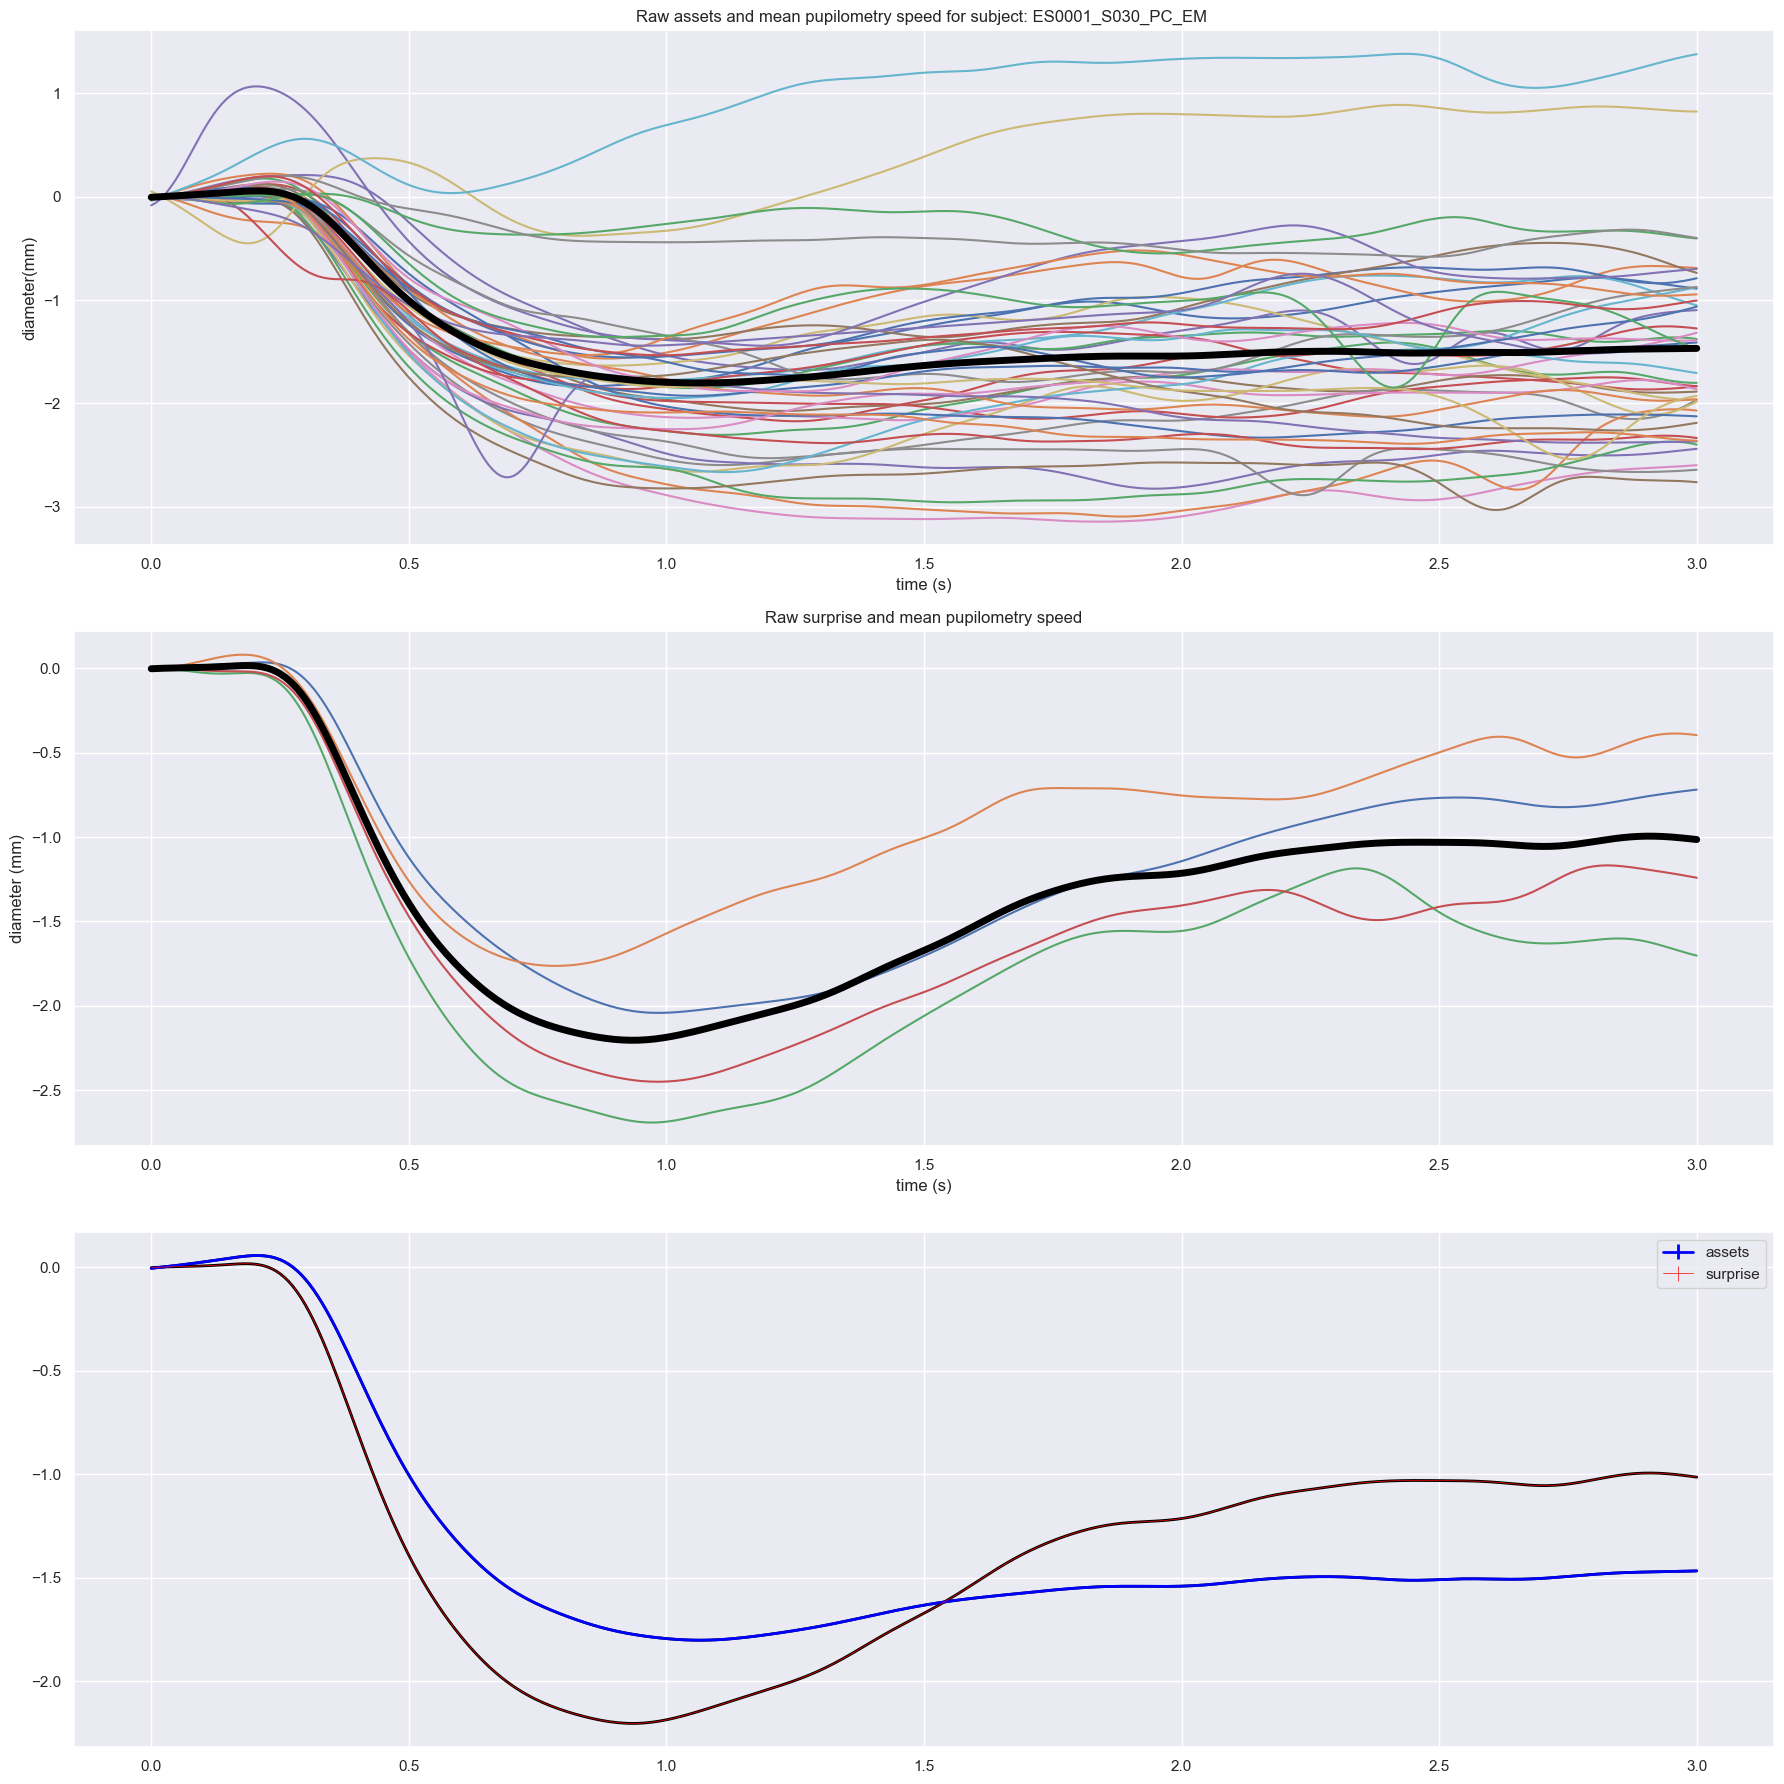

In [23]:
window_frames=df_concat.index.max()+1#np.round(windows_s*120).astype(int)
window=range(0,window_frames)
time_x=np.linspace(0,windows_s,window_frames)
%matplotlib inline
df_concat_mean=df_concat_group.mean()
df_concat_std=df_concat_group.std()

filter_assets=list(df_concat_mean.columns)
filter_surprise=list(df_concat_mean.columns)

filter_assets=[asset for asset in filter_assets if 'Asset' in asset ]
filter_surprise=[asset for asset in filter_surprise if 'Surprise' in asset ]

mat=df_concat_mean.reindex(columns=filter_assets).values
mat_std=df_concat_std.reindex(columns=filter_assets).values

mat2=df_concat_mean.reindex(columns= filter_surprise).values
mat2_std=df_concat_std.reindex(columns= filter_surprise).values

fig, ax=plt.subplots(3,1,)
ax[0].plot(time_x,mat)
ax[0].plot(time_x,np.mean(mat,axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax[0].set_title(f'Raw assets and mean pupilometry speed for subject: {subject} ')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('diameter(mm)')


ax[1].plot(time_x,mat2)
ax[1].plot(time_x,np.mean(mat2,axis=1),linewidth=5,color='black')
ax[1].set_title('Raw surprise and mean pupilometry speed')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('diameter (mm)')

ax[2].errorbar(time_x,np.mean(mat,axis=1),np.std(mat_std,axis=1),linewidth=2,color='blue')
ax[2].errorbar(time_x,np.mean(mat2,axis=1),np.std(mat2_std,axis=1),linewidth=0.5,color='red')
ax[2].legend(['assets','surprise'])
ax[2].plot(time_x,np.mean(mat2,axis=1),linewidth=2,color='black')
ax[2].plot(time_x,np.mean(mat,axis=1),linewidth=2,color='black')

fig.set_size_inches((18, 18))
fig.tight_layout()
fig.savefig(f'figures/{subject}_data_assets.png', dpi=300)

In [24]:
mat_mean=np.mean(mat,axis=1)
mat2_mean=np.mean(mat2,axis=1)

mat_mean.T

array([-5.74106300e-03, -3.46469523e-03, -1.17623839e-03,  1.12771608e-03,
        3.45195657e-03,  5.80232398e-03,  8.18536686e-03,  1.06079966e-02,
        1.30771402e-02,  1.55993870e-02,  1.81806321e-02,  2.08257095e-02,
        2.35379629e-02,  2.63186502e-02,  2.91660448e-02,  3.20741198e-02,
        3.50307934e-02,  3.80158162e-02,  4.09984377e-02,  4.39350057e-02,
        4.67666527e-02,  4.94172357e-02,  5.17916942e-02,  5.37749615e-02,
        5.52315311e-02,  5.60057830e-02,  5.59232227e-02,  5.47927926e-02,
        5.24103118e-02,  4.85630129e-02,  4.30351162e-02,  3.56143531e-02,
        2.60992488e-02,  1.43068196e-02,  8.02041636e-05, -1.67043067e-02,
       -3.61313392e-02, -5.82420159e-02, -8.30313457e-02, -1.10447556e-01,
       -1.40393334e-01, -1.72728850e-01, -2.07276418e-01, -2.43826492e-01,
       -2.82144556e-01, -3.21978361e-01, -3.63065028e-01, -4.05137700e-01,
       -4.47931546e-01, -4.91188985e-01, -5.34664057e-01, -5.78125983e-01,
       -6.21362020e-01, -

In [49]:
from pyplr.plr import PLR
ONSET_IDX = 6

plr = PLR(pupil_diameter_df['Asset0041'],
          sample_rate=122,
          onset_idx=6,
          stim_duration=1)


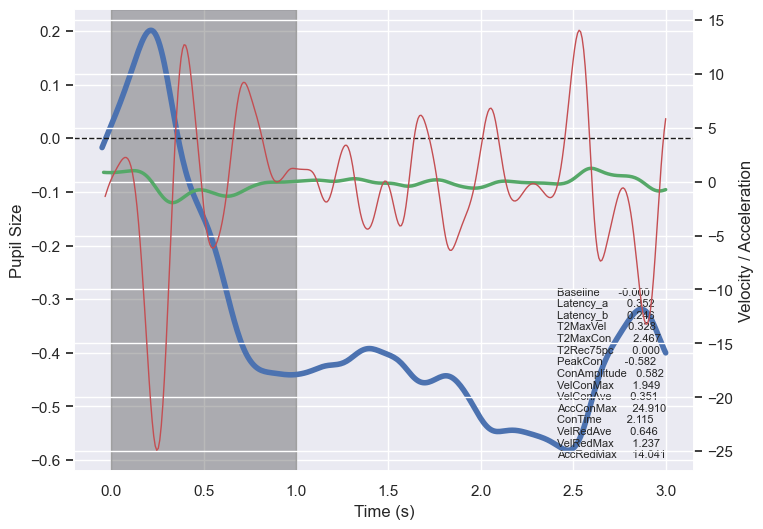

In [50]:
%matplotlib inline
fig = plr.plot(vel=True, acc=True, print_params=True)


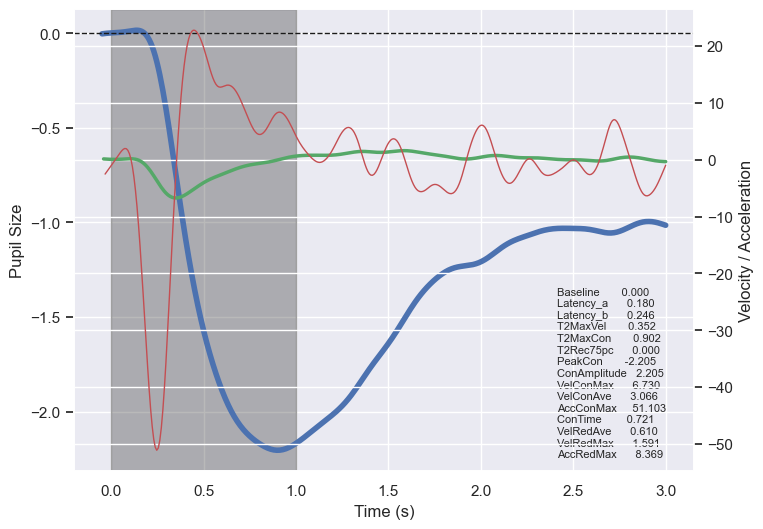

In [27]:
from pyplr.plr import PLR
ONSET_IDX = 6

plr = PLR(mat2_mean,
          sample_rate=122,
          onset_idx=6,
          stim_duration=1)
fig = plr.plot(vel=True, acc=True, print_params=True)


In [31]:
pupil_params=plr.parameters()

In [17]:
pupil_events_speed=np.abs(np.diff(mat))/(1/SAMPLE_RATE)
pupil_surprise_speed=np.abs(np.diff(mat2))/(1/SAMPLE_RATE)


In [18]:
%matplotlib qt

pupil_events_speed
pupil_surprise_speed

fig, ax=plt.subplots(1,1)
ax.plot(time_x,pupil_events_speed[window])
ax.plot(time_x,np.mean(pupil_events_speed[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')

fig, ax=plt.subplots(1,1)
ax.plot(time_x,pupil_surprise_speed[window,:])
ax.plot(time_x,np.mean(pupil_surprise_speed[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(time_x,np.mean(pupil_surprise_speed[window,:],axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.mean(pupil_events_speed[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

Text(0, 0.5, 'speed (s)')